In [4]:
import pandas as pd
import numpy as np
import re
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

print("Libraries imported successfully!")

Libraries imported successfully!


In [5]:
df = pd.read_csv('D:\AutoJudge_v2\data\data_cleaned.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (4999, 10)

Columns: ['title', 'description', 'input_description', 'output_description', 'problem_class', 'problem_score', 'combined_text', 'problem_class_encoded', 'text_length', 'word_count']

First few rows:


,title,description,input_description,output_description,problem_class,problem_score,combined_text,problem_class_encoded,text_length,word_count
0,Digits,John gave Jack a very hard problem. He wrote a...,First line contains a positive integer N (1 ≤ ...,"Output exactly three lines, the steps Jack nee...",hard,7.95,Digits John gave Jack a very hard problem. He ...,1,2058,401
1,Neural Network country,Due to the recent popularity of the Deep learn...,The first line of input contains N (1 ≤ N ≤ 10...,"Output a single integer, the number of paths D...",hard,5.91,Neural Network country Due to the recent popul...,1,1911,359
2,Property,Bill is a famous mathematician in BubbleLand. ...,The first line contains one integer number n (...,Output contains n distinct integers separated ...,hard,6.32,Property Bill is a famous mathematician in Bub...,1,1947,386
3,Exploration plan,The competitors of Bubble Cup X gathered after...,"The first line contains four integers: V, E, N...",Output a single integer that represents the mi...,hard,6.32,Exploration plan The competitors of Bubble Cup...,1,2432,476
4,Casinos and travel,John has just bought a new car and is planning...,"In the first line, a positive integer N (1 ≤ N...","Output one number, the answer to the problem m...",hard,6.32,Casinos and travel John has just bought a new ...,1,2540,508


***Manual Feature Extraction***

In [6]:
def extract_basic_features(text):
    """
    Extract basic text statistics
    
    Returns:
        dict: Dictionary containing basic features
    """
    if pd.isna(text) or text == '':
        return {
            'char_count': 0,
            'word_count': 0,
            'sentence_count': 0,
            'avg_word_length': 0,
            'uppercase_count': 0,
            'digit_count': 0
        }
    
    words = text.split()
    
    return {
        'char_count': len(text),
        'word_count': len(words),
        'sentence_count': len(re.findall(r'[.!?]+', text)),
        'avg_word_length': np.mean([len(w) for w in words]) if words else 0,
        'uppercase_count': sum(1 for c in text if c.isupper()),
        'digit_count': sum(1 for c in text if c.isdigit())
    }

def extract_math_features(text):
    """
    Extract mathematical and special symbol features
    
    Returns:
        dict: Dictionary containing math-related features
    """
    if pd.isna(text) or text == '':
        return {
            'math_symbol_count': 0,
            'equation_count': 0,
            'bracket_count': 0,
            'dollar_sign_count': 0
        }
    
    return {
        'math_symbol_count': len(re.findall(r'[+\-*/=<>≤≥≠]', text)),
        'equation_count': len(re.findall(r'\$.*?\$', text)),
        'bracket_count': len(re.findall(r'[\(\)\[\]\{\}]', text)),
        'dollar_sign_count': text.count('$')
    }

def extract_keyword_features(text):
    """
    Extract features based on algorithm-related keywords
    
    Returns:
        dict: Dictionary containing keyword counts
    """
    if pd.isna(text) or text == '':
        return {
            'graph_keywords': 0,
            'dp_keywords': 0,
            'sorting_keywords': 0,
            'data_structure_keywords': 0,
            'complexity_keywords': 0
        }
    
    text_lower = text.lower()
    
    # Define keyword categories
    graph_words = ['graph', 'node', 'edge', 'tree', 'dfs', 'bfs', 'dijkstra', 
                   'spanning', 'path', 'cycle', 'vertex', 'connected']
    dp_words = ['dynamic', 'dp', 'memoization', 'optimal', 'subproblem', 
                'recursion', 'recurrence', 'state']
    sort_words = ['sort', 'sorted', 'order', 'arrange', 'ascending', 
                  'descending', 'sequence']
    ds_words = ['array', 'list', 'stack', 'queue', 'heap', 'hash', 'map', 
                'set', 'dictionary', 'linked']
    complexity_words = ['O(n)', 'O(log n)', 'complexity', 'efficient', 
                       'optimize', 'time limit', 'nlogn', 'polynomial']
    
    return {
        'graph_keywords': sum(text_lower.count(w) for w in graph_words),
        'dp_keywords': sum(text_lower.count(w) for w in dp_words),
        'sorting_keywords': sum(text_lower.count(w) for w in sort_words),
        'data_structure_keywords': sum(text_lower.count(w) for w in ds_words),
        'complexity_keywords': sum(text_lower.count(w) for w in complexity_words)
    }

In [7]:
# Extracting all manual features
print("="*60)
print("EXTRACTING MANUAL FEATURES")
print("="*60)

print("\n1. Extracting basic features...")
basic_features = df['combined_text'].apply(extract_basic_features)
basic_df = pd.DataFrame(basic_features.tolist())

print("2. Extracting math features...")
math_features = df['combined_text'].apply(extract_math_features)
math_df = pd.DataFrame(math_features.tolist())

print("3. Extracting keyword features...")
keyword_features = df['combined_text'].apply(extract_keyword_features)
keyword_df = pd.DataFrame(keyword_features.tolist())

EXTRACTING MANUAL FEATURES

1. Extracting basic features...
2. Extracting math features...
3. Extracting keyword features...


In [8]:
# Combining all manual features
manual_features = pd.concat([basic_df, math_df, keyword_df], axis=1)
print(f"\n✓ Manual features extracted!")
print(f"  Shape: {manual_features.shape}")
print(f"  Features: {manual_features.columns.tolist()}")


✓ Manual features extracted!
  Shape: (4999, 15)
  Features: ['char_count', 'word_count', 'sentence_count', 'avg_word_length', 'uppercase_count', 'digit_count', 'math_symbol_count', 'equation_count', 'bracket_count', 'dollar_sign_count', 'graph_keywords', 'dp_keywords', 'sorting_keywords', 'data_structure_keywords', 'complexity_keywords']


In [9]:
print("\nSample manual features:")
manual_features.head()


Sample manual features:


,char_count,word_count,sentence_count,avg_word_length,uppercase_count,digit_count,math_symbol_count,equation_count,bracket_count,dollar_sign_count,graph_keywords,dp_keywords,sorting_keywords,data_structure_keywords,complexity_keywords
0,2058,401,28,4.134663,42,52,19,0,8,0,0,0,1,0,0
1,1911,359,16,4.325905,42,39,9,8,14,16,6,1,0,1,0
2,1947,386,22,4.046632,68,79,53,4,26,8,4,0,2,0,0
3,2432,476,16,4.111345,58,39,15,0,12,0,2,0,0,1,0
4,2540,508,25,4.001969,52,45,11,0,10,0,3,1,0,0,0


***Feature Statistics and Analysis***

In [10]:
print("\n" + "="*60)
print("MANUAL FEATURE STATISTICS")
print("="*60)

print("\nDescriptive statistics:")
manual_features.describe()


MANUAL FEATURE STATISTICS

Descriptive statistics:


,char_count,word_count,sentence_count,avg_word_length,uppercase_count,digit_count,math_symbol_count,equation_count,bracket_count,dollar_sign_count,graph_keywords,dp_keywords,sorting_keywords,data_structure_keywords,complexity_keywords
count,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000
mean,1957.134227,348.034207,19.663933,4.634286,30.095819,39.677135,13.112422,58.439888,22.829366,116.881776,3.068814,0.596119,1.893979,2.025605,0.039608
std,856.798052,149.662046,8.826950,0.463656,18.297523,31.943656,11.305348,64.054354,21.898742,128.111117,8.483281,1.111939,3.708728,4.186019,0.448678
min,61.000000,8.000000,0.000000,3.159864,1.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1385.500000,249.000000,14.000000,4.323697,19.000000,18.000000,6.000000,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1860.000000,330.000000,18.000000,4.625000,26.000000,32.000000,10.000000,48.000000,16.000000,96.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,2380.000000,425.000000,24.000000,4.898805,36.000000,52.000000,17.000000,102.000000,29.500000,204.000000,1.000000,1.000000,2.000000,2.000000,0.000000
max,13003.000000,2150.000000,113.000000,8.363029,453.000000,314.000000,141.000000,423.000000,368.000000,846.000000,127.000000,18.000000,54.000000,40.000000,17.000000


In [11]:
# Correlation with target variable
print("\n" + "="*60)
print("CORRELATION WITH PROBLEM SCORE")
print("="*60)

correlations = manual_features.corrwith(df['problem_score']).sort_values(ascending=False)
print("\nFeature correlations with problem_score:")
print(correlations)


CORRELATION WITH PROBLEM SCORE

Feature correlations with problem_score:
graph_keywords             0.230420
word_count                 0.224777
char_count                 0.218142
sentence_count             0.178055
math_symbol_count          0.159086
bracket_count              0.155642
dp_keywords                0.148323
uppercase_count            0.135887
digit_count                0.129770
dollar_sign_count          0.074096
equation_count             0.074092
complexity_keywords        0.044216
data_structure_keywords    0.032520
sorting_keywords           0.015785
avg_word_length           -0.019413
dtype: float64


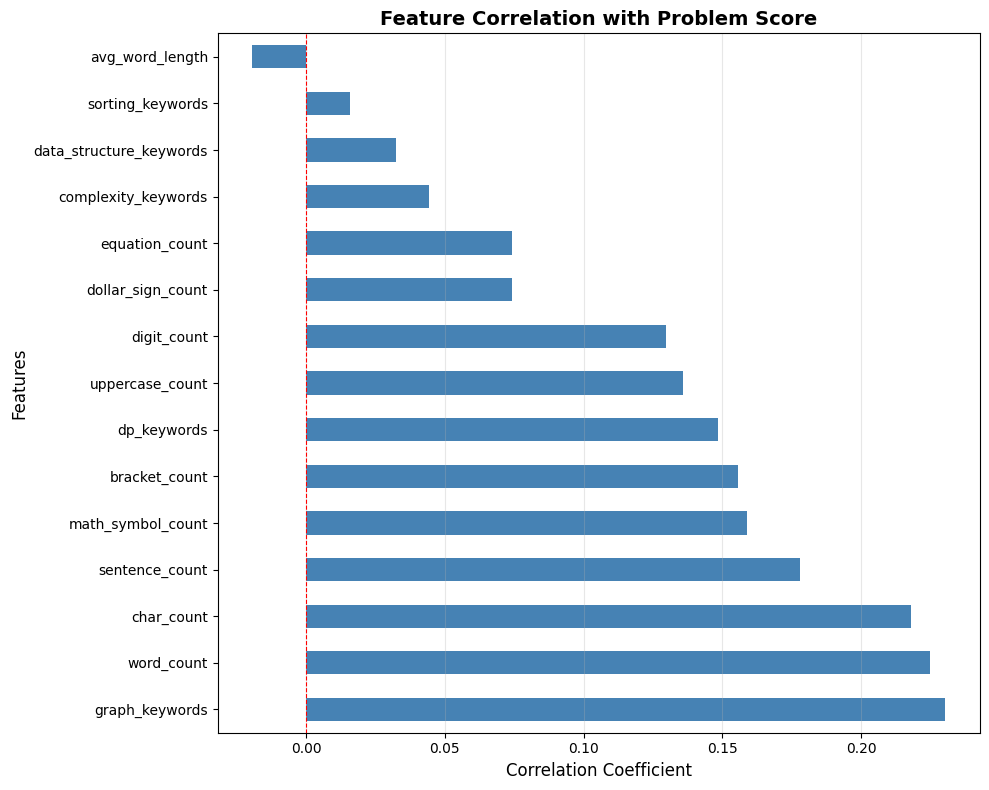

In [12]:
# Visualizing correlations
plt.figure(figsize=(10, 8))
correlations.plot(kind='barh', color='steelblue')
plt.title('Feature Correlation with Problem Score', fontsize=14, fontweight='bold')
plt.xlabel('Correlation Coefficient', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.axvline(x=0, color='red', linestyle='--', linewidth=0.8)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

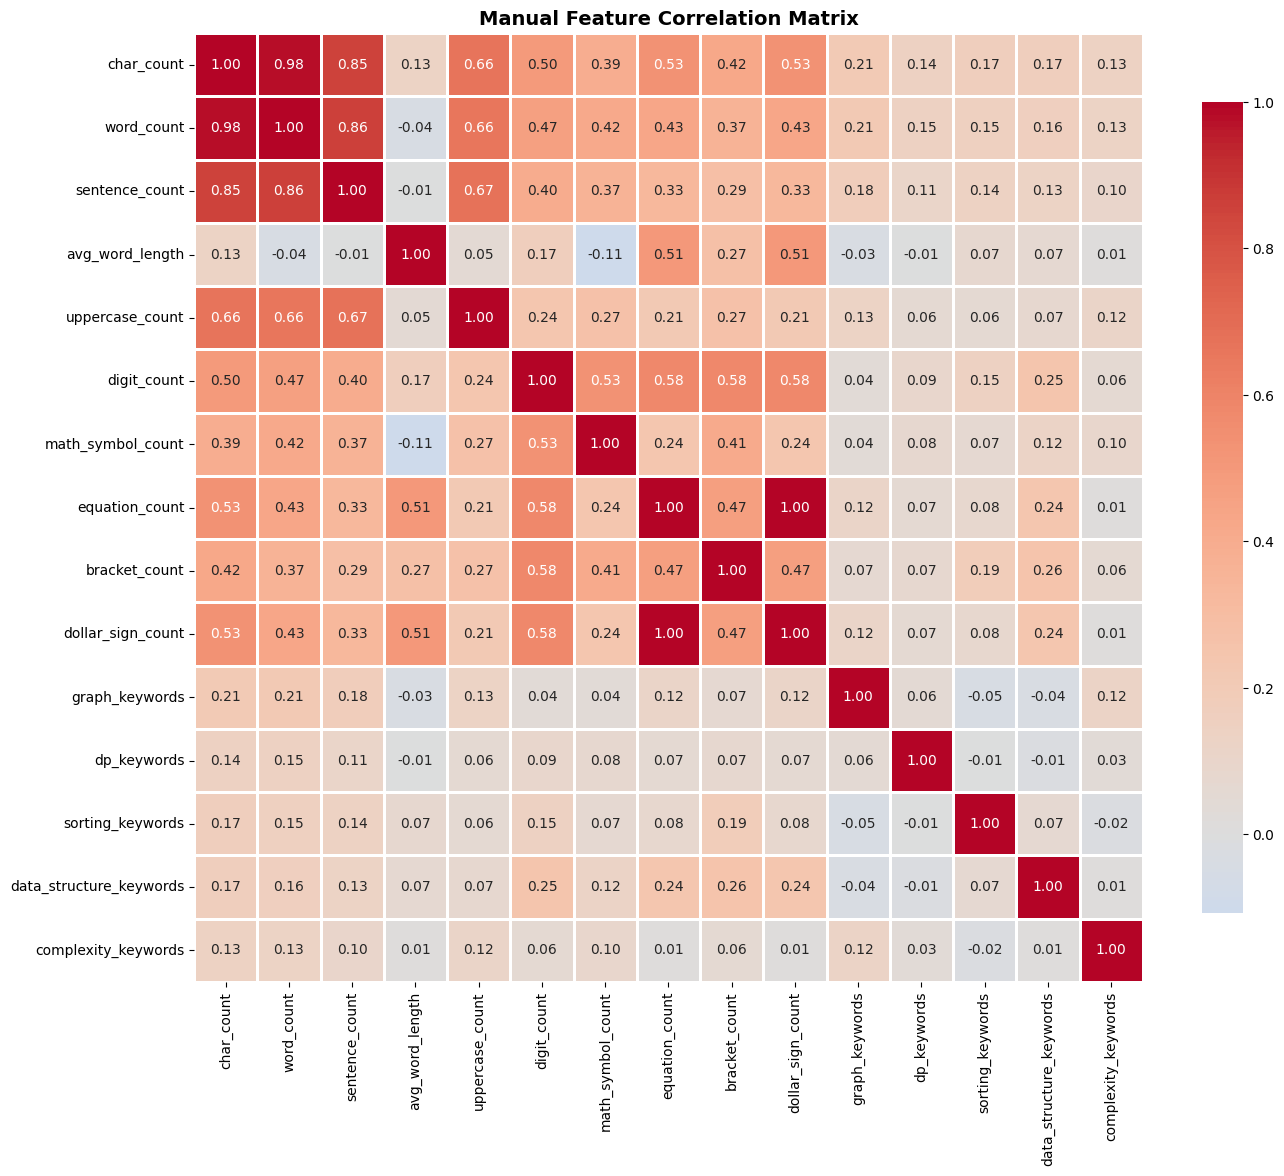

In [13]:
# Feature correlation heatmap
plt.figure(figsize=(14, 12))
correlation_matrix = manual_features.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Manual Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [14]:
#Feature Distribution by Class

print("\n" + "="*60)
print("FEATURE DISTRIBUTION BY DIFFICULTY CLASS")
print("="*60)


FEATURE DISTRIBUTION BY DIFFICULTY CLASS


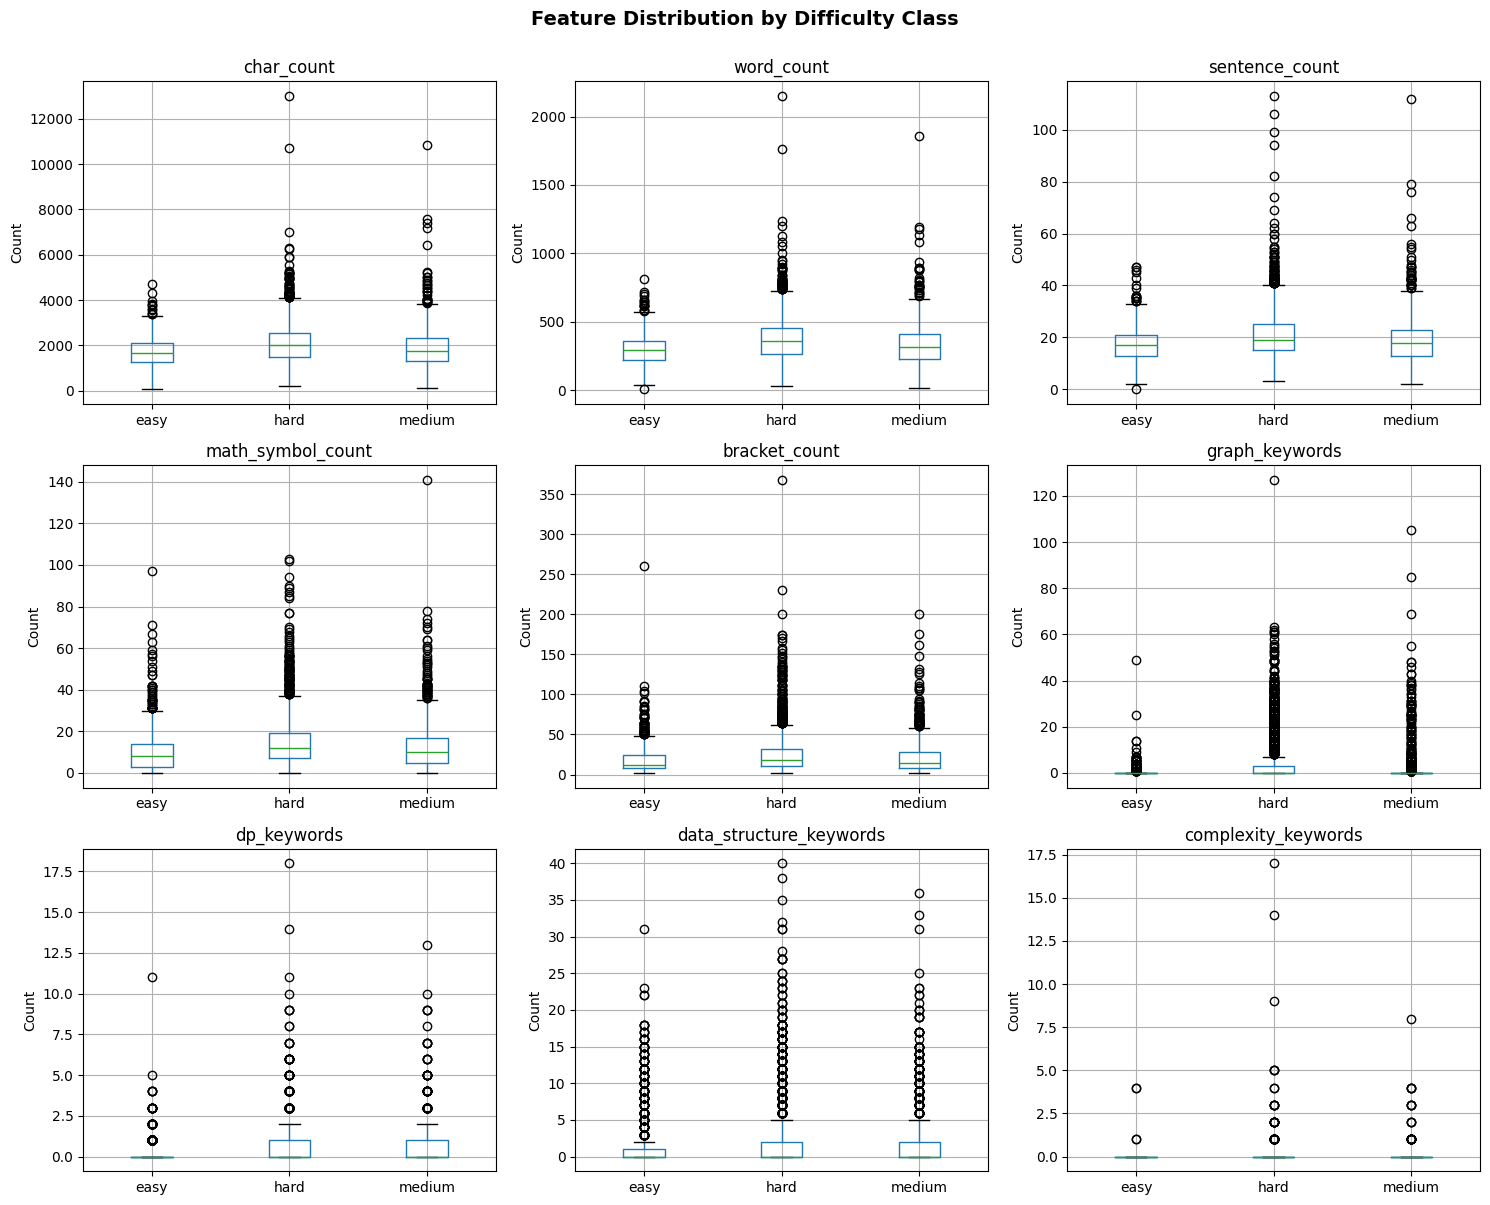

In [15]:
# Box plots for selected features
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()

selected_features = [
    'char_count', 'word_count', 'sentence_count', 
    'math_symbol_count', 'bracket_count', 'graph_keywords',
    'dp_keywords', 'data_structure_keywords', 'complexity_keywords'
]

for idx, feature in enumerate(selected_features):
    df_plot = pd.DataFrame({
        'feature': manual_features[feature],
        'class': df['problem_class']
    })
    
    df_plot.boxplot(column='feature', by='class', ax=axes[idx])
    axes[idx].set_title(feature)
    axes[idx].set_xlabel('')
    axes[idx].set_ylabel('Count')

plt.suptitle('Feature Distribution by Difficulty Class', 
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

In [16]:
# Statistical comparison by class
print("\nMean features by class:")
feature_by_class = manual_features.copy()
feature_by_class['problem_class'] = df['problem_class']
print(feature_by_class.groupby('problem_class').mean())


Mean features by class:
                char_count  word_count  sentence_count  avg_word_length  \
problem_class                                                             
easy           1705.974696  301.224696       17.477733         4.678955   
hard           2100.645712  374.793558       20.886302         4.610919   
medium         1872.278243  332.196653       18.973501         4.645501   

               uppercase_count  digit_count  math_symbol_count  \
problem_class                                                    
easy                 27.062753    34.739879          10.051619   
hard                 31.880093    42.912689          14.534342   
medium               28.979079    37.264296          12.665969   

               equation_count  bracket_count  dollar_sign_count  \
problem_class                                                     
easy                58.430162      18.267206         116.862348   
hard                61.361661      25.417540         122.725650   


***TF-IDF Feature Extraction***

In [17]:
# Creating TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=500,           # Top 500 features
    min_df=2,                   # Ignore terms appearing in < 2 documents
    max_df=0.8,                 # Ignore terms appearing in > 80% of documents
    ngram_range=(1, 2),         # Use unigrams and bigrams
    stop_words='english',       # Remove common English stop words
    strip_accents='unicode',    # Remove accents
    lowercase=True              # Convert to lowercase
)

print("\nFitting TF-IDF vectorizer...")
print(f"Parameters:")
print(f"  - max_features: 500")
print(f"  - ngram_range: (1, 2)")
print(f"  - min_df: 2")
print(f"  - max_df: 0.8")


Fitting TF-IDF vectorizer...
Parameters:
  - max_features: 500
  - ngram_range: (1, 2)
  - min_df: 2
  - max_df: 0.8


In [18]:
# Fit and transform
tfidf_features = tfidf_vectorizer.fit_transform(df['combined_text'])

print(f"\n✓ TF-IDF features extracted!")
print(f"  Shape: {tfidf_features.shape}")
print(f"  Sparse matrix size: {tfidf_features.data.nbytes / 1024:.2f} KB")


✓ TF-IDF features extracted!
  Shape: (4999, 500)
  Sparse matrix size: 2147.85 KB


In [19]:
# Getting feature names
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"  Number of features: {len(tfidf_feature_names)}")

  Number of features: 500


In [20]:
# Sample features
print(f"\nSample TF-IDF features:")
print(tfidf_feature_names[:20])


Sample TF-IDF features:
['000' '10' '10 le' '10 number' '10 test' '100' '100 number' '1000' '105'
 '106' '109' '11' '12' '15' '20' '200' '50' 'a1' 'a1 a2' 'a2']


In [21]:
# Converting to dense format for analysis
tfidf_dense = tfidf_features.toarray()
tfidf_df = pd.DataFrame(tfidf_dense, columns=tfidf_feature_names)


TOP TF-IDF FEATURES BY DIFFICULTY CLASS

Top 15 features for 'easy' problems:
test          0.115865
le            0.092249
case          0.077919
test case     0.075534
string        0.060131
array         0.049021
leq           0.048014
integer       0.046848
cases         0.044967
test cases    0.044930
10            0.038917
second        0.038553
le le         0.038324
print         0.033903
example       0.033567
dtype: float64


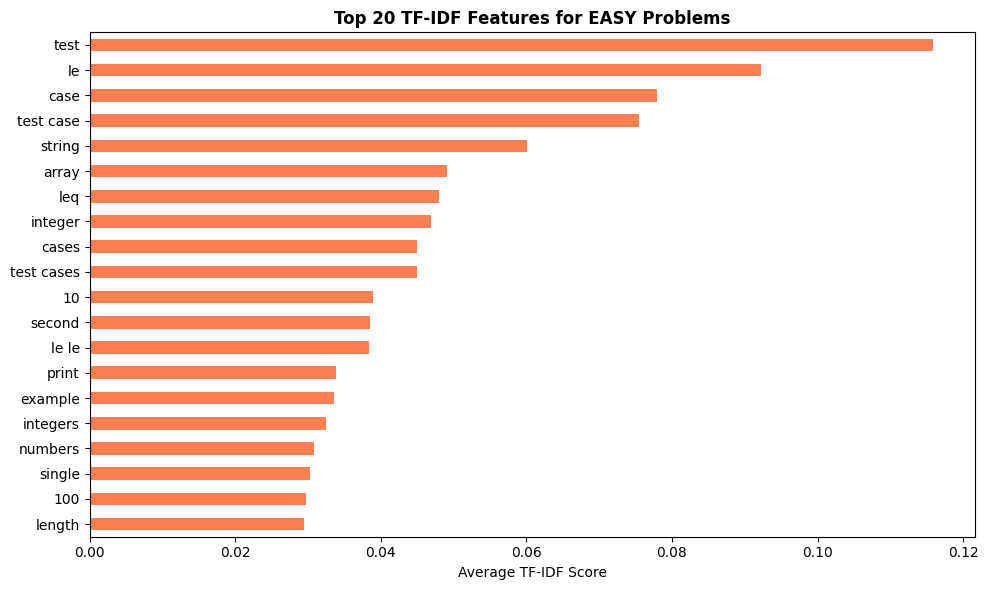


Top 15 features for 'hard' problems:
le          0.084176
leq         0.048942
integers    0.044843
test        0.043205
th          0.041543
10          0.040223
string      0.040126
tree        0.037653
array       0.036816
integer     0.035291
print       0.031607
vertices    0.031072
sequence    0.030933
second      0.030857
numbers     0.030594
dtype: float64


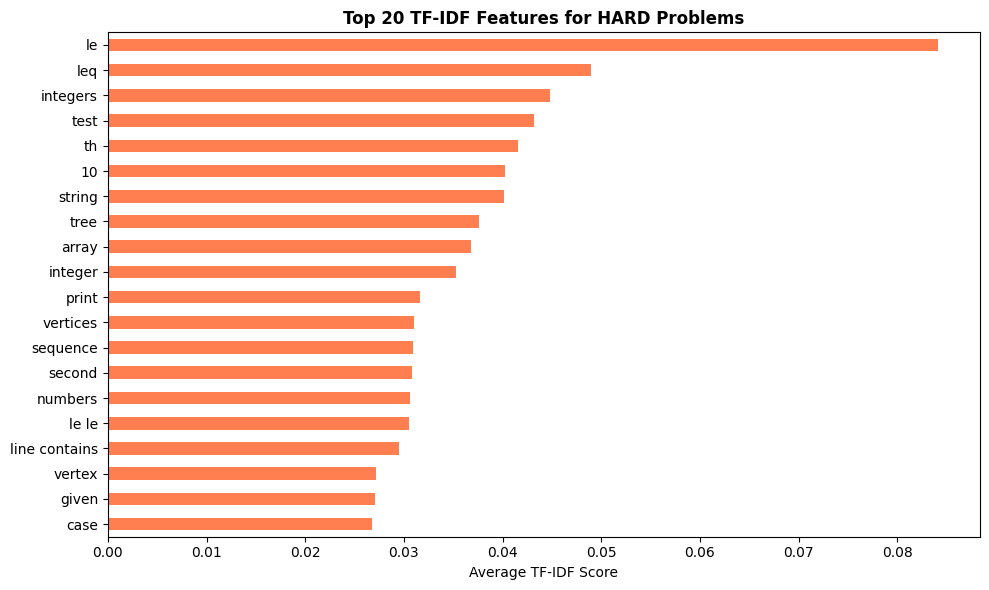


Top 15 features for 'medium' problems:
le           0.082163
test         0.068168
array        0.048918
string       0.047113
10           0.045025
case         0.041731
integers     0.041354
integer      0.040048
test case    0.039167
th           0.035115
print        0.034181
leq          0.033912
second       0.032184
le le        0.030350
sequence     0.029899
dtype: float64


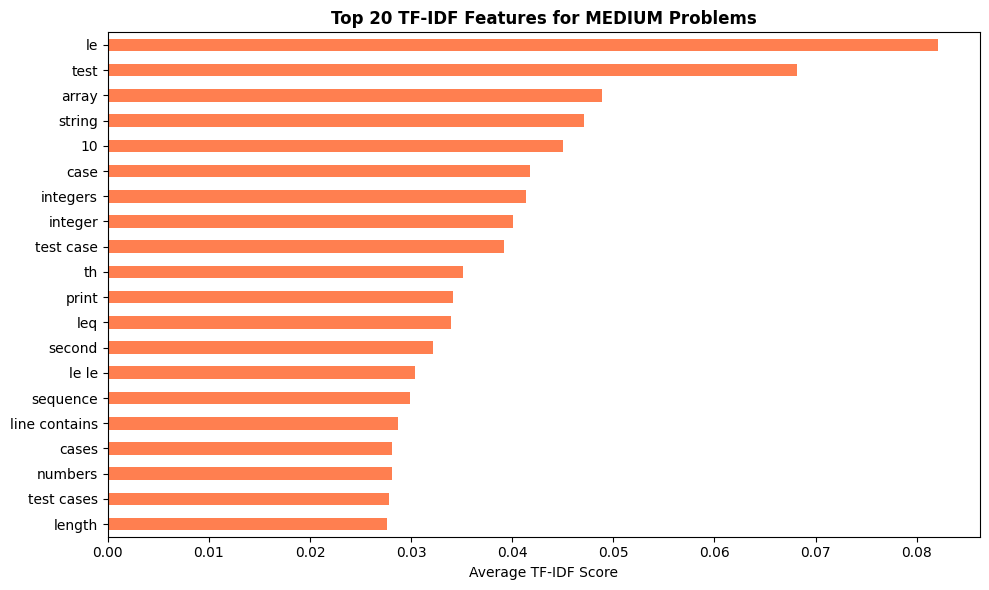

In [22]:
#Top TF-IDF Features by Class

print("\n" + "="*60)
print("TOP TF-IDF FEATURES BY DIFFICULTY CLASS")
print("="*60)

for cls in sorted(df['problem_class'].unique()):
    class_mask = df['problem_class'] == cls
    class_tfidf = tfidf_df[class_mask].mean().sort_values(ascending=False)
    
    print(f"\nTop 15 features for '{cls}' problems:")
    print(class_tfidf.head(15))
    
    # Visualizing
    plt.figure(figsize=(10, 6))
    class_tfidf.head(20).plot(kind='barh', color='coral')
    plt.title(f'Top 20 TF-IDF Features for {cls.upper()} Problems', 
              fontsize=12, fontweight='bold')
    plt.xlabel('Average TF-IDF Score')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

In [23]:
# Combining manual features with TF-IDF
combined_features = pd.concat([
    manual_features.reset_index(drop=True),
    tfidf_df.reset_index(drop=True)
], axis=1)

print(f"Combined features shape: {combined_features.shape}")
print(f"Total number of features: {combined_features.shape[1]}")
print(f"  - Manual features: {len(manual_features.columns)}")
print(f"  - TF-IDF features: {len(tfidf_feature_names)}")


Combined features shape: (4999, 515)
Total number of features: 515
  - Manual features: 15
  - TF-IDF features: 500


In [24]:
# Adding target variables
combined_features['problem_class'] = df['problem_class'].values
combined_features['problem_class_encoded'] = df['problem_class_encoded'].values
combined_features['problem_score'] = df['problem_score'].values

print("\n✓ All features combined successfully!")


✓ All features combined successfully!


In [25]:
# Feature Scaling

print("\n" + "="*60)
print("FEATURE SCALING")
print("="*60)

# We'll scale only the manual features (TF-IDF is already normalized)
manual_feature_cols = manual_features.columns.tolist()

print(f"\nScaling {len(manual_feature_cols)} manual features...")
print("Note: TF-IDF features are already normalized")


FEATURE SCALING

Scaling 15 manual features...
Note: TF-IDF features are already normalized


In [26]:
# Creating and fitting scaler
scaler = StandardScaler()
scaled_manual = scaler.fit_transform(manual_features)
scaled_manual_df = pd.DataFrame(scaled_manual, columns=manual_feature_cols)

print("\n✓ Manual features scaled!")


✓ Manual features scaled!


In [27]:
# Comparing before and after scaling
print("\nBefore scaling (first 5 features):")
print(manual_features[manual_feature_cols[:5]].describe())

print("\nAfter scaling (first 5 features):")
print(scaled_manual_df[manual_feature_cols[:5]].describe())


Before scaling (first 5 features):
         char_count   word_count  sentence_count  avg_word_length  \
count   4999.000000  4999.000000     4999.000000      4999.000000   
mean    1957.134227   348.034207       19.663933         4.634286   
std      856.798052   149.662046        8.826950         0.463656   
min       61.000000     8.000000        0.000000         3.159864   
25%     1385.500000   249.000000       14.000000         4.323697   
50%     1860.000000   330.000000       18.000000         4.625000   
75%     2380.000000   425.000000       24.000000         4.898805   
max    13003.000000  2150.000000      113.000000         8.363029   

       uppercase_count  
count      4999.000000  
mean         30.095819  
std          18.297523  
min           1.000000  
25%          19.000000  
50%          26.000000  
75%          36.000000  
max         453.000000  

After scaling (first 5 features):
         char_count    word_count  sentence_count  avg_word_length  \
count  4.999

***Creating Final Feature Set***

In [28]:
# Combining scaled manual features with TF-IDF
final_features = pd.concat([
    scaled_manual_df.reset_index(drop=True),
    tfidf_df.reset_index(drop=True)
], axis=1)

# Adding target variables
final_features['problem_class'] = df['problem_class'].values
final_features['problem_class_encoded'] = df['problem_class_encoded'].values
final_features['problem_score'] = df['problem_score'].values

print("\n" + "="*60)
print("FINAL FEATURE SET")
print("="*60)
print(f"Shape: {final_features.shape}")
print(f"Total features: {final_features.shape[1] - 3} (excluding targets)")
print(f"\nFeature breakdown:")
print(f"  - Scaled manual features: {len(manual_feature_cols)}")
print(f"  - TF-IDF features: {len(tfidf_feature_names)}")
print(f"  - Target variables: 3")


FINAL FEATURE SET
Shape: (4999, 518)
Total features: 515 (excluding targets)

Feature breakdown:
  - Scaled manual features: 15
  - TF-IDF features: 500
  - Target variables: 3


***Saving All Artifacts***

In [29]:
# ---------- Paths ----------
DATA_DIR = Path(r"D:\AutoJudge_v2\data")
MODELS_DIR = Path(r"D:\AutoJudge_v2\models")

DATA_DIR.mkdir(exist_ok=True)
MODELS_DIR.mkdir(exist_ok=True)

# ---------- 1. Save combined features (unscaled manual + TF-IDF) ----------
combined_features_path = DATA_DIR / "features_combined.csv"
combined_features.to_csv(combined_features_path, index=False)
print(f"✓ Saved: {combined_features_path}")

# ---------- 2. Save final features (scaled manual + TF-IDF) ----------
final_features_path = DATA_DIR / "features_final.csv"
final_features.to_csv(final_features_path, index=False)
print(f"✓ Saved: {final_features_path}")

# ---------- 3. Save TF-IDF vectorizer ----------
tfidf_vectorizer_path = MODELS_DIR / "tfidf_vectorizer.pkl"
with open(tfidf_vectorizer_path, 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)
print(f"✓ Saved: {tfidf_vectorizer_path}")

# ---------- 4. Save feature scaler ----------
feature_scaler_path = MODELS_DIR / "feature_scaler.pkl"
with open(feature_scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"✓ Saved: {feature_scaler_path}")

# ---------- 5. Save feature names ----------
feature_info = {
    'manual_features': manual_feature_cols,
    'tfidf_features': tfidf_feature_names.tolist(),
    'all_features': list(final_features.columns[:-3])  # Exclude target columns
}

feature_names_path = MODELS_DIR / "feature_names.pkl"
with open(feature_names_path, 'wb') as f:
    pickle.dump(feature_info, f)
print(f"✓ Saved: {feature_names_path}")

# ---------- 6. Save feature statistics ----------
feature_stats = {
    'manual_features': {
        'count': len(manual_feature_cols),
        'names': manual_feature_cols,
        'correlations': correlations.to_dict()
    },
    'tfidf_features': {
        'count': len(tfidf_feature_names),
        'vocabulary_size': len(tfidf_vectorizer.vocabulary_),
        'params': tfidf_vectorizer.get_params()
    },
    'total_features': final_features.shape[1] - 3
}

feature_stats_path = MODELS_DIR / "feature_statistics.pkl"
with open(feature_stats_path, 'wb') as f:
    pickle.dump(feature_stats, f)
print(f"✓ Saved: {feature_stats_path}")

✓ Saved: D:\AutoJudge_v2\data\features_combined.csv
✓ Saved: D:\AutoJudge_v2\data\features_final.csv
✓ Saved: D:\AutoJudge_v2\models\tfidf_vectorizer.pkl
✓ Saved: D:\AutoJudge_v2\models\feature_scaler.pkl
✓ Saved: D:\AutoJudge_v2\models\feature_names.pkl
✓ Saved: D:\AutoJudge_v2\models\feature_statistics.pkl


***Summary Report***

In [30]:
print("\n" + "="*60)
print("FEATURE ENGINEERING SUMMARY REPORT")
print("="*60)

print(f"""
Dataset Information:
  - Total samples: {len(df)}
  - Total features: {final_features.shape[1] - 3}
  
Manual Features ({len(manual_feature_cols)} features):
  1. Basic features: char_count, word_count, sentence_count, avg_word_length, uppercase_count, digit_count
  2. Math features: math_symbol_count, equation_count, bracket_count, dollar_sign_count
  3. Keyword features: graph_keywords, dp_keywords, sorting_keywords, data_structure_keywords, complexity_keywords
  
TF-IDF Features ({len(tfidf_feature_names)} features):
  - Vocabulary size: {len(tfidf_vectorizer.vocabulary_)}
  - N-gram range: (1, 2)
  - Min document frequency: 2
  - Max document frequency: 0.8
  
Top Correlated Features with Problem Score:
""")

for feat, corr in correlations.head(5).items():
    print(f"  {feat}: {corr:.4f}")

print(f"""
Files Generated:
  ✓ features_combined.csv - Unscaled features + targets
  ✓ features_final.csv - Scaled features + targets (ready for ML)
  ✓ tfidf_vectorizer.pkl - For transforming new text
  ✓ feature_scaler.pkl - For scaling new manual features
  ✓ feature_names.pkl - Feature metadata
  ✓ feature_statistics.pkl - Feature statistics
""")

print("\n" + "="*60)
print("FEATURE ENGINEERING COMPLETE! 🎉")
print("="*60)


FEATURE ENGINEERING SUMMARY REPORT

Dataset Information:
  - Total samples: 4999
  - Total features: 515

Manual Features (15 features):
  1. Basic features: char_count, word_count, sentence_count, avg_word_length, uppercase_count, digit_count
  2. Math features: math_symbol_count, equation_count, bracket_count, dollar_sign_count
  3. Keyword features: graph_keywords, dp_keywords, sorting_keywords, data_structure_keywords, complexity_keywords

TF-IDF Features (500 features):
  - Vocabulary size: 500
  - N-gram range: (1, 2)
  - Min document frequency: 2
  - Max document frequency: 0.8

Top Correlated Features with Problem Score:

  graph_keywords: 0.2304
  word_count: 0.2248
  char_count: 0.2181
  sentence_count: 0.1781
  math_symbol_count: 0.1591

Files Generated:
  ✓ features_combined.csv - Unscaled features + targets
  ✓ features_final.csv - Scaled features + targets (ready for ML)
  ✓ tfidf_vectorizer.pkl - For transforming new text
  ✓ feature_scaler.pkl - For scaling new manual 